##  Importing all the useful Libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt 
import nibabel as nib   # Use for reading and writing neuroimaging file formats (like NIfTI)
import glob             # Use for finding the file of specific formats (txt_files = glob.glob("*.txt") give all txt file)    
from tensorflow.keras.utils import to_categorical # Help to convert integer labels to one-hot encoded categorical labels
from sklearn.preprocessing import MinMaxScaler # Used for scaling teh array to a given range (e.g., 0 to 1).
# from tifffile import imsave 
import os

from tqdm import tqdm  #  Visual progress bar in the terminal or notebook    80%|███████████████▍    | 16/20 
import random
import plotly.graph_objects as go
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from ipywidgets import interact, FloatSlider   # Use for making Intract
import ipywidgets as widgets
from tensorflow.keras.models import load_model

In [2]:
scaler = MinMaxScaler()

In [3]:
TRAIN_DATASET_PATH = r"D:\archive\BraTS2021_Training_Data" ## Dataset Folder
subject_id = "BraTS2021_00520" # This specific file from the data folder
flair_filename = f"{subject_id}_flair.nii.gz"   # file formate
flair_image_path = os.path.join(TRAIN_DATASET_PATH, subject_id, flair_filename)  # Construct the full path
print(f"Attempting to load from: {flair_image_path}") # Print the path we're trying to load
test_image_flair = nib.load(flair_image_path).get_fdata()    
print(f"Successfully loaded FLAIR image for {subject_id}")
print(f"Image data shape: {test_image_flair.shape}")
print(f"Data type: {test_image_flair.dtype}")

Attempting to load from: D:\archive\BraTS2021_Training_Data\BraTS2021_00520\BraTS2021_00520_flair.nii.gz
Successfully loaded FLAIR image for BraTS2021_00520
Image data shape: (240, 240, 155)
Data type: float64


## Without applying MimMaxScaler()

Shape :(240, 240)
Maximum Pixel Value in array :2022.0


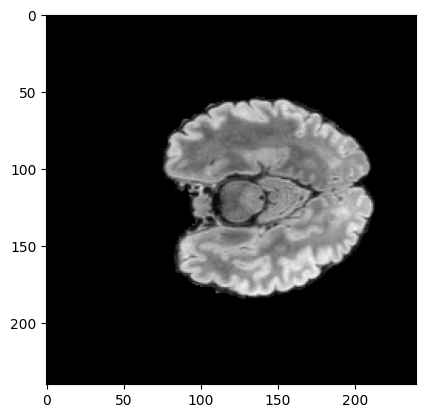

In [4]:
# Get the 1/3 slice along the Z-axis
z=3  
slice_z = test_image_flair.shape[2] //z # Integer division to get the 1/3 index of 155
slice_data = test_image_flair[:, :, slice_z]
# Display the slice using matplotlib
plt.imshow(slice_data, cmap='gray')
print(f"Shape :{slice_data.shape}")
print(f"Maximum Pixel Value in array :{max(max(row) for row in slice_data)}")

## With Applying MinMaxScalar()

Shape :(128, 128)
Maximum Pixel Value in array after applying MinMaxScalar :0.9999999999999999


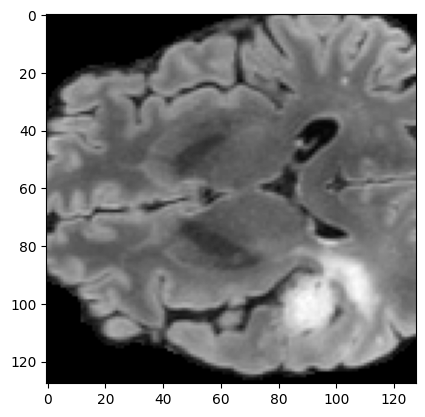

In [5]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape by (MinMaxScalar)
test_image_flair_MS=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
z=2
slice_z = test_image_flair_MS.shape[2] //z # Integer division to get the middle index
slice_data = test_image_flair_MS[56:184, 56:184, slice_z]
# Display the slice using matplotlib
plt.imshow(slice_data, cmap='gray')
print(f"Shape :{slice_data.shape}")
print(f"Maximum Pixel Value in array after applying MinMaxScalar :{max(max(row) for row in slice_data)}")

## Croping the image 

In [6]:
subject_id = "BraTS2021_00520"   ## Select file Number 502 from the dataset
## Combined all the channel
seg_filename = f"{subject_id}_seg.nii.gz" 
t1_filename = f"{subject_id}_t1.nii.gz" 
t1ce_filename = f"{subject_id}_t1ce.nii.gz" 
t2_filename = f"{subject_id}_t2.nii.gz" 
flair_filename = f"{subject_id}_flair.nii.gz"

t1_image_path=os.path.join(TRAIN_DATASET_PATH,subject_id,t1_filename) 
t1ce_image_path=os.path.join(TRAIN_DATASET_PATH,subject_id,t1ce_filename)
flair_image_path = os.path.join(TRAIN_DATASET_PATH, subject_id, flair_filename)

test_image_t1ce=nib.load(t1_image_path).get_fdata()
test_image_t2=nib.load(t1ce_image_path).get_fdata()
test_image_flair=nib.load(flair_image_path).get_fdata()

## Applying MinMaxScalar()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1,test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1,test_image_t2.shape[-1])).reshape(test_image_t2.shape)
# test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1,test_image_flair.shape[-1])).reshape(test_image_flair.shape)

## croping the data 
test_image_t1ce=test_image_t1ce[56:184,56:184,:]
test_image_t2=test_image_t2[56:184,56:184,:]
test_image_flair=test_image_flair[56:184,56:184,:]

print(test_image_t1ce.shape)
print(test_image_t2.shape)
print(test_image_flair.shape)

(128, 128, 155)
(128, 128, 155)
(128, 128, 155)


## Ploting all the image in single plot and each having same slice

In [7]:

# Set your dataset path and subject ID
TRAIN_DATASET_PATH = r"D:\archive\BraTS2021_Training_Data"
subject_id = "BraTS2021_00605"
modalities = ["flair", "t1", "t1ce", "t2", "seg"]

# Load all images into a dictionary (load once)
images = {}
for mod in modalities:
    path = os.path.join(TRAIN_DATASET_PATH, subject_id, f"{subject_id}_{mod}.nii.gz")
    images[mod] = nib.load(path).get_fdata()

# Interactive plotting function
def plot_slices(z=2.0):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    flair_shape = images["flair"].shape
    slice_idx = int(flair_shape[2] // z)
    
    for i, (mod, data) in enumerate(images.items()):
        ax = axes[i]
        if mod == "seg":
            ax.imshow(data[56:184, 56:184, slice_idx], cmap='nipy_spectral', vmin=0, vmax=4)
        else:
            ax.imshow(data[56:184, 56:184, slice_idx], cmap='gray')
        ax.set_title(f'{mod.upper()} - Slice {slice_idx}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create an interactive widget
interact(plot_slices, z=FloatSlider(min=1.1, max=4.0, step=0.1, value=2.0, description="Z Divider"))

interactive(children=(FloatSlider(value=2.0, description='Z Divider', max=4.0, min=1.1), Output()), _dom_class…

<function __main__.plot_slices(z=2.0)>

## Combine all the file (test by using one file only )

In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)   ## stacking all 3 file to one npy format
file_location='D:\\archive\\archive\\BraTS2021_Training_Data\\test_combine.npy'
np.save(file_location, combined_x)

## Loading the combined image

In [ ]:
test_image_npfile = np.load(file_location)  ## Load the compile file 
print(test_image_npfile.shape)
flair_test=test_image_npfile[:, :, :, 1]    ## Loading one of the file from 3 
slide_idx=flair_test.shape[2]//2  
plt.imshow(flair_test[:,:,slide_idx], cmap='grey')  ## ploting the image                

## Applying this on all the dataset 

In [8]:
# Configuration for Image Modalities (flair, t1ce, t2)
TRAIN_DATASET_PATH = r"D:\archive\BraTS2021_Training_Data"
# Output directory for combined, processed image modalities
OUTPUT_NPY_DIR_IMG = "D:\\archive\\Images"
# Limit for the number of subjects to process for image modalities
NUM_SUBJECTS_TO_PROCESS_IMG = 1000 ## we can change according to our need 

# --- Configuration for Segmentation Masks (seg) ---
# Output directory for processed segmentation masks
OUTPUT_NPY_DIR_SEG = "D:\\archive\\Masks"  
# Limit for the number of subjects to process for segmentation masks
NUM_SUBJECTS_TO_PROCESS_SEG = 1000 

# Create output directories if they don't exist
os.makedirs(OUTPUT_NPY_DIR_IMG, exist_ok=True)
os.makedirs(OUTPUT_NPY_DIR_SEG, exist_ok=True)

In [9]:
# Get all subject IDs from the training dataset path
subject_ids_raw = [d for d in os.listdir(TRAIN_DATASET_PATH)
                   if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))
                   and d.startswith("BraTS2021_")]

# Sort subject IDs to ensure consistent processing order for "first N" subjects
subject_ids_raw.sort()

print(f"Found {len(subject_ids_raw)} potential subject folders in total.")

# --- Section 1: Processing Image Modalities (flair, t1ce, t2) ---
print(f"\n Starting processing for Image Modalities (flair, t1ce, t2) ")
print(f"Will process the first {NUM_SUBJECTS_TO_PROCESS_IMG} subjects for images.")

# Define the modalities to combine for image data
modalities_to_combine_img = ["flair", "t1ce", "t2"]

Found 1251 potential subject folders in total.

 Starting processing for Image Modalities (flair, t1ce, t2) 
Will process the first 1000 subjects for images.


In [10]:
processed_count_img = 0
# Iterate through subjects, limiting to the configured number for images
for subject_id in tqdm(subject_ids_raw, desc="Processing Image Modalities"):
    if processed_count_img >= NUM_SUBJECTS_TO_PROCESS_IMG:
        print(f"Reached the limit of {NUM_SUBJECTS_TO_PROCESS_IMG} subjects for image modalities. Stopping.")
        break

    subject_folder_path = os.path.join(TRAIN_DATASET_PATH, subject_id)
    loaded_and_processed_modalities_data = []
    missing_modality_found = False

    # Load, scale, and crop each required image modality
    for modality in modalities_to_combine_img:
        file_name = f"{subject_id}_{modality}.nii.gz"
        file_path = os.path.join(subject_folder_path, file_name)

        if os.path.exists(file_path):
            try:
                img_data = nib.load(file_path).get_fdata()
                original_shape = img_data.shape
                # Reshape to 2D for MinMaxScaler (flatten all pixels, 1 feature dimension)
                img_data_flat = img_data.reshape(-1, 1)
                # Apply Min-Max Scaling to normalize pixel values between 0 and 1Az
                scaled_img_data = scaler.fit_transform(img_data_flat).reshape(original_shape)
                # Crop the image spatially (keeping all slices in the last dimension)
                cropped_img_data = scaled_img_data[56:184, 56:184, 13:141]
                loaded_and_processed_modalities_data.append(cropped_img_data)
            except Exception as e:
                print(f"  Error processing {modality} for {subject_id}: {e}")
                missing_modality_found = True
                break # Stop processing this subject if any modality fails
        else:
            print(f"  Missing {modality} file for {subject_id} at {file_path}")
            missing_modality_found = True
            break # Stop processing this subject if any file is missing

    if missing_modality_found:
        print(f"  Skipping {subject_id} for image modalities due to missing or errored files.")
        continue # Move to the next subject

    # Ensure all loaded modalities have consistent shapes before stacking
    if loaded_and_processed_modalities_data:
        first_shape = loaded_and_processed_modalities_data[0].shape
        if not all(data.shape == first_shape for data in loaded_and_processed_modalities_data):
            print(f"  Warning: Image modalities for {subject_id} have inconsistent shapes after processing. Skipping.")
            continue

        try:
            # Stack the 3D images into a 4D array along a new axis (axis=3)
            # The order of channels will be [flair, t1ce, t2]
            combined_x_img = np.stack(loaded_and_processed_modalities_data, axis=3)
            output_npy_file_img = os.path.join(OUTPUT_NPY_DIR_IMG, f"{subject_id}_combined_processed_img.npy")
            # Save the combined, processed image array
            np.save(output_npy_file_img, combined_x_img)
            processed_count_img += 1 # Increment counter only upon successful save
        except Exception as e:
            print(f"  Error stacking or saving image data for {subject_id}: {e}")
    else:
        print(f"  No valid image modalities loaded for {subject_id}. Skipping.")

print(f"\nProcessing of Image Modalities complete. Processed {processed_count_img} subjects.")
print(f"Combined image .npy files are saved in: {OUTPUT_NPY_DIR_IMG}") 

Processing Image Modalities:   0%|          | 5/1251 [00:09<40:06,  1.93s/it]


KeyboardInterrupt: 

## Saving the Mask(Categorical)
As label 3 has no information so it is useless , it only increase the computation so we change the label 4 to label 3 

In [12]:
mask_filename = f"{subject_id}_seg.nii.gz" 
mask_image_path=os.path.join(TRAIN_DATASET_PATH,subject_id,mask_filename)
mask_img=nib.load(mask_image_path).get_fdata()
mask_img[mask_img == 4] = 3
temp_mask = to_categorical(mask_img, num_classes=4)
temp_mask_cls=temp_mask[56:184,56:184,155//2,1]

## Apply same thing one all the dataset

In [13]:
# Processing Segmentation Masks (seg) 
print(f"\n--- Starting processing for Segmentation Masks (seg) ---")
print(f"Will process the first {NUM_SUBJECTS_TO_PROCESS_SEG} subjects for masks.")


--- Starting processing for Segmentation Masks (seg) ---
Will process the first 1000 subjects for masks.


In [14]:
processed_count_seg = 0
# Iterate through subjects, limiting to the configured number for masks
for subject_id in tqdm(subject_ids_raw, desc="Processing Segmentation Masks"):
    if processed_count_seg >= NUM_SUBJECTS_TO_PROCESS_SEG:
        print(f"Reached the limit of {NUM_SUBJECTS_TO_PROCESS_SEG} subjects for segmentation masks. Stopping.")
        break

    subject_folder_path = os.path.join(TRAIN_DATASET_PATH, subject_id)
    mask_file_name = f"{subject_id}_seg.nii.gz"
    mask_file_path = os.path.join(subject_folder_path, mask_file_name)

    if os.path.exists(mask_file_path):
        try:
            mask_img = nib.load(mask_file_path).get_fdata()

            # Convert mask data to integer type for to_categorical, as it expects integer labels
            mask_img = mask_img.astype(np.uint8)

            # Modify mask values: change all instances of label 4 to 3
            mask_img[mask_img == 4] = 3

            # Apply one-hot encoding using to_categorical.
            # This will convert the mask (e.g., HxWxD) into a 4D array (HxWxDx4),
            # where the last dimension represents the categorical classes.
            mask_img_categorical = to_categorical(mask_img, num_classes=4)

            # Crop the categorical mask spatially, keeping all slices and all channels
            # The crop dimensions [56:184, 56:184, 13:141, :] are consistent with image cropping,
            # applying to the first two dimensions (height and width) and retaining depth and channels.
            cropped_mask_img = mask_img_categorical[56:184, 56:184, 13:141, :]

            # Convert to float32 as requested.
            # Be aware that this will increase file size compared to uint8.
            cropped_mask_img = cropped_mask_img.astype(np.float32)


            # Define the output .npy file path for this subject's processed mask
            output_npy_file_seg = os.path.join(OUTPUT_NPY_DIR_SEG, f"{subject_id}_processed_seg.npy")

            # Save the processed mask array with compression for reduced file size
            np.savez_compressed(output_npy_file_seg, cropped_mask_img)
            processed_count_seg += 1 # Increment counter only upon successful save

        except Exception as e:
            print(f"    Error processing segmentation mask for {subject_id}: {e}")
            continue # Move to the next subject if mask processing fails
    else:
        print(f"    Missing segmentation mask file for {subject_id} at {mask_file_path}. Skipping.")
        continue # Move to the next subject if file is missing

print(f"\nProcessing of Segmentation Masks complete. Processed {processed_count_seg} subjects.")
print(f"Compressed mask .npy files are saved in: {OUTPUT_NPY_DIR_SEG}")

print("\nAll processing tasks complete.")

Processing Segmentation Masks:  80%|███████▉  | 1000/1251 [08:48<02:12,  1.89it/s]

Reached the limit of 1000 subjects for segmentation masks. Stopping.

Processing of Segmentation Masks complete. Processed 1000 subjects.
Compressed mask .npy files are saved in: D:\archive\Masks

All processing tasks complete.


## Data Generator

In [8]:
def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        path = os.path.join(img_dir, image_name)

        if image_name.endswith('.npy'):
            img_array = np.load(path).astype(np.float32)  # Cast here

        elif image_name.endswith('.npz'):
            data = np.load(path)
            first_key = list(data.keys())[0]
            img_array = data[first_key].astype(np.float32)  # Cast here

        else:
            continue  # skip unsupported formats

        images.append(img_array)

    images = np.array(images)
    return images

In [9]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    print("Total images:", L)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            print("Loading batch:", batch_start, "to", limit)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            print("Loaded shapes: ", X.shape, Y.shape)
            yield (X, Y)
            batch_start += batch_size
            batch_end += batch_size

In [ ]:
# Dummy directories and files for demonstration
# os.makedirs(r"D:\MRI_Dataset\Training\Images", exist_ok=True)
# os.makedirs(r"D:\MRI_Dataset\Training\Masks", exist_ok=True)
# os.makedirs(r"D:\MRI_Dataset\Validation\Images", exist_ok=True)
# os.makedirs(r"D:\MRI_Dataset\Validation\Masks", exist_ok=True)
# os.makedirs(r"D:\MRI_Dataset\Test\Images",exist_ok=True)
# os.makedirs(r"D:\MRI_Dataset\Test\Masks",exist_ok=True)


In [10]:
train_img_dir = r"D:\MRI_Dataset\Training\Image"
train_mask_dir = r"D:\MRI_Dataset\Training\Mask"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_dir = r"D:\MRI_Dataset\Validation\Image"
val_mask_dir = r"D:\MRI_Dataset\Validation\Mask"
val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

test_img_dir= r"D:\MRI_Dataset\Test\Image"
test_mask_dir= r"D:\MRI_Dataset\Test\Mask"
test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

In [11]:
print(train_img_list)
print(train_mask_list)
print(val_img_list)
print(val_mask_list)
print(test_img_list)
print(test_mask_list)

['BraTS2021_00000_combined_processed_img.npy', 'BraTS2021_00002_combined_processed_img.npy', 'BraTS2021_00003_combined_processed_img.npy', 'BraTS2021_00005_combined_processed_img.npy', 'BraTS2021_00006_combined_processed_img.npy', 'BraTS2021_00008_combined_processed_img.npy', 'BraTS2021_00009_combined_processed_img.npy', 'BraTS2021_00011_combined_processed_img.npy', 'BraTS2021_00012_combined_processed_img.npy', 'BraTS2021_00014_combined_processed_img.npy', 'BraTS2021_00016_combined_processed_img.npy', 'BraTS2021_00017_combined_processed_img.npy', 'BraTS2021_00018_combined_processed_img.npy', 'BraTS2021_00019_combined_processed_img.npy', 'BraTS2021_00020_combined_processed_img.npy', 'BraTS2021_00021_combined_processed_img.npy', 'BraTS2021_00022_combined_processed_img.npy', 'BraTS2021_00024_combined_processed_img.npy', 'BraTS2021_00025_combined_processed_img.npy', 'BraTS2021_00026_combined_processed_img.npy', 'BraTS2021_00028_combined_processed_img.npy', 'BraTS2021_00030_combined_process

In [12]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                 train_mask_dir, train_mask_list, batch_size=2)
val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                 val_mask_dir, val_mask_list, batch_size=2)
test_img_datagen=imageLoader(test_img_dir,test_img_list,
                                 test_mask_dir, test_mask_list, batch_size=2)

In [16]:
msk = np.random.randint(0, 2, size=(10, 256, 256, 3)) #10 masks, 256x256, 3 classes (one-hot or similar)
msk = msk.astype(np.float32) # Ensure it's float32 initially as per your load_img

In [13]:
img, msk = next(train_img_datagen)
print(f"Original msk dtype after loading: {msk.dtype}")

Total images: 800
Loading batch: 0 to 2
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
Original msk dtype after loading: float32


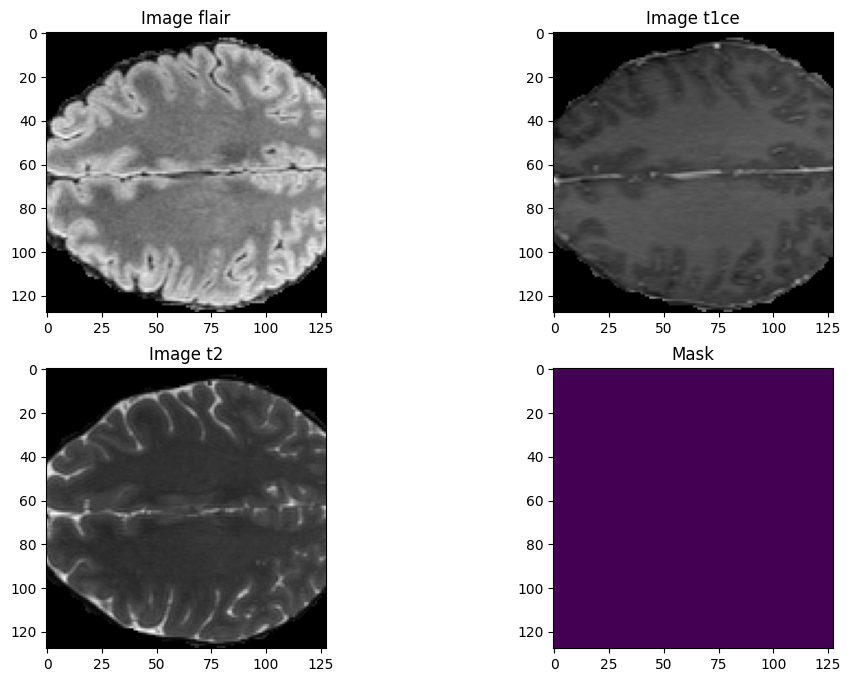

In [14]:
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)
# test_mask = np.argmax(test_mask, axis=3).astype(np.float64)
n_slice = random.randint(0, test_mask.shape[2] - 1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()

## Model
#### 📥 Input
- Shape: (128, 128, 128, 3)

###  Contracting Path (Encoder)
1. **Block 1**
   - Conv3D (16 filters, 3×3×3) → ReLU
   - Dropout (0.1)
   - Conv3D (16 filters, 3×3×3) → ReLU
   - MaxPooling3D (2×2×2)
   
2. **Block 2**
   - Conv3D (32 filters, 3×3×3) → ReLU
   - Dropout (0.1)
   - Conv3D (32 filters, 3×3×3) → ReLU
   - MaxPooling3D (2×2×2)

3. **Block 3**
   - Conv3D (64 filters, 3×3×3) → ReLU
   - Dropout (0.2)
   - Conv3D (64 filters, 3×3×3) → ReLU
   - MaxPooling3D (2×2×2)

4. **Block 4**
   - Conv3D (128 filters, 3×3×3) → ReLU
   - Dropout (0.2)
   - Conv3D (128 filters, 3×3×3) → ReLU
   - MaxPooling3D (2×2×2)

### Bottleneck
- Conv3D (256 filters, 3×3×3) → ReLU
- Dropout (0.3)
- Conv3D (256 filters, 3×3×3) → ReLU

### Expansive Path (Decoder) 
1. **Block 5**
   - Conv3DTranspose (128 filters, 2×2×2) + Concatenate with Block 4
   - Conv3D (128 filters, 3×3×3) → ReLU
   - Dropout (0.2)
   - Conv3D (128 filters, 3×3×3) → ReLU

2. **Block 6**
   - Conv3DTranspose (64 filters, 2×2×2) + Concatenate with Block 3
   - Conv3D (64 filters, 3×3×3) → ReLU
   - Dropout (0.2)
   - Conv3D (64 filters, 3×3×3) → ReLU

3. **Block 7**
   - Conv3DTranspose (32 filters, 2×2×2) + Concatenate with Block 2
   - Conv3D (32 filters, 3×3×3) → ReLU
   - Dropout (0.1)
   - Conv3D (32 filters, 3×3×3) → ReLU

4. **Block 8**
   - Conv3DTranspose (16 filters, 2×2×2) + Concatenate with Block 1
   - Conv3D (16 filters, 3×3×3) → ReLU
   - Dropout (0.1)
   - Conv3D (16 filters, 3×3×3) → ReLU

### Output
- Conv3D (num_classes = 4, 1×1×1 kernel, softmax activation)



In [15]:
kernel_initializer =  'he_uniform' #Try others if you want


# ################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [16]:
# import keras
from tensorflow import keras

#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm # type: ignore
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `keras` framework.


## For training from scratch 

In [21]:
#Fit the model 
batch_size=2

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


## Training

In [22]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Loading batch: 2 to 4
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
Loading batch: 4 to 6
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
Epoch 1/5
  1/400 ━━━━━━━━━━━━━━━━━━━━ 1:54:33 17s/step - accuracy: 0.0993 - iou_score: 1.3192e-10 - loss: 1.0203Loading batch: 6 to 8
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  2/400 ━━━━━━━━━━━━━━━━━━━━ 47:40 7s/step - accuracy: 0.1044 - iou_score: 1.6702e-10 - loss: 1.0205   Loading batch: 8 to 10
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  3/400 ━━━━━━━━━━━━━━━━━━━━ 43:57 7s/step - accuracy: 0.1099 - iou_score: 8.0015e-10 - loss: 1.0207Loading batch: 10 to 12
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  4/400 ━━━━━━━━━━━━━━━━━━━━ 43:40 7s/step - accuracy: 0.1186 - iou_score: 1.0460e-09 - loss: 1.0204Loading batch: 12 to 14
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  5/400 ━━━━━━━━━━━━━━━━━━━━ 42:21 6s/step - accuracy: 0.1278 - iou_score: 9.5598e-07 -

In [ ]:
# import tensorflow as tf
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

## Saving the model

In [39]:
model.save('my_model.keras')

## Load the model

In [17]:

def comparison(model_path, test_img_datagen, batch_size=2, 
                                         img_height=128, img_width=128, img_depth=128, 
                                         num_classes=4, num_visualizations=2, channel_to_display=1):
    # Load model
    model = load_model(model_path, compile=False)
    # Get a batch of test images and masks
    test_image_batch, test_mask_batch = next(test_img_datagen)

    # Run model prediction
    test_pred_batch = model.predict(test_image_batch)
    
    # Convert predictions and masks to class labels (argmax)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

    # Visualization
    for i in range(min(batch_size, num_visualizations)):
        n_slice = np.random.randint(0, test_pred_batch_argmax.shape[2])  # Random slice along depth
        plt.figure(figsize=(12, 8))

        plt.subplot(1, 3, 1)
        plt.imshow(test_image_batch[i, :, :, n_slice, channel_to_display], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(test_mask_batch_argmax[i, :, :, n_slice], cmap='viridis')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(test_pred_batch_argmax[i, :, :, n_slice], cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Loading batch: 6 to 8
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


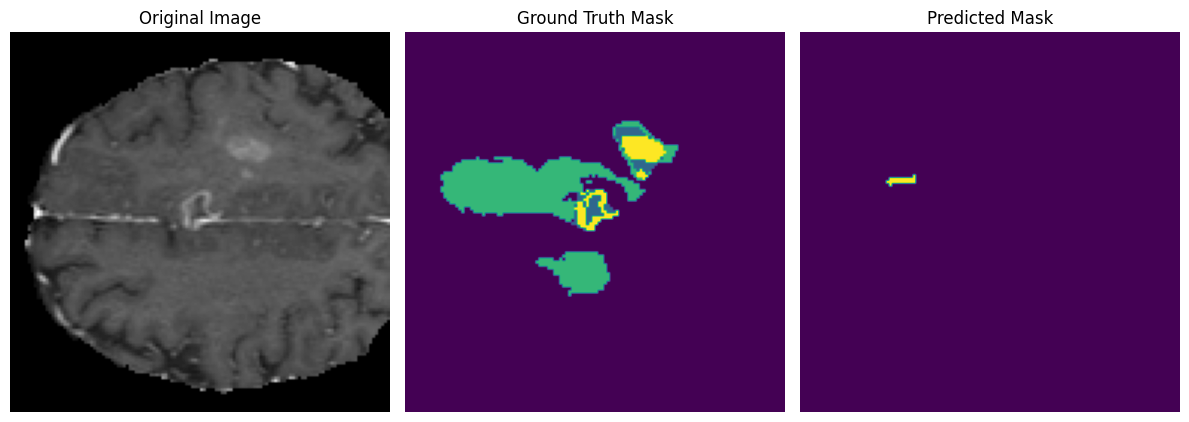

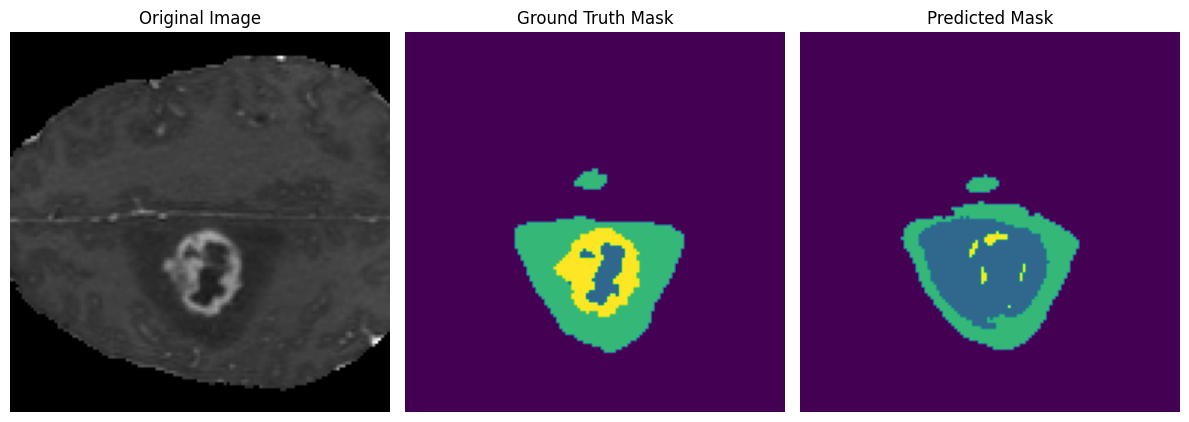

In [21]:
model_path=r"D:\Users\rusha\my_model.keras"
comparison(model_path,test_img_datagen, batch_size=2, 
                                         img_height=128, img_width=128, img_depth=128, 
                                         num_classes=4, num_visualizations=2, channel_to_display=1)

## Re-training

In [43]:
my_model=load_model(r"D:\Users\rusha\my_model.keras",compile=False)  ## Load the model
my_model.compile(optimizer = optim, loss=total_loss, metrics=metrics)   ## Compile it 
print(my_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None


In [44]:
history=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Loading batch: 18 to 20
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
Loading batch: 20 to 22
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
Epoch 1/5
  1/400 ━━━━━━━━━━━━━━━━━━━━ 1:11:46 11s/step - accuracy: 0.9773 - iou_score: 0.2453 - loss: 0.9560Loading batch: 22 to 24
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  2/400 ━━━━━━━━━━━━━━━━━━━━ 33:20 5s/step - accuracy: 0.9790 - iou_score: 0.3114 - loss: 0.9298   Loading batch: 24 to 26
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  3/400 ━━━━━━━━━━━━━━━━━━━━ 31:03 5s/step - accuracy: 0.9781 - iou_score: 0.3383 - loss: 0.9197Loading batch: 26 to 28
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  4/400 ━━━━━━━━━━━━━━━━━━━━ 30:21 5s/step - accuracy: 0.9767 - iou_score: 0.3548 - loss: 0.9130Loading batch: 28 to 30
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
  5/400 ━━━━━━━━━━━━━━━━━━━━ 29:59 5s/step - accuracy: 0.9759 - iou_score: 0.3650 - loss: 0.9089

KeyboardInterrupt: 

In [40]:
batch = next(iter(train_img_datagen))
print(type(batch), batch[0].shape)

Loading batch: 22 to 24
Loaded shapes:  (2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
<class 'tuple'> (2, 128, 128, 128, 3)


In [38]:
## Save the model again



## Load the new model



## Test it 